<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Э
В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 8.9 MB/s eta 0:00:00


Импорт необходимых библиотек

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [ ]:
# Загрузим датасет
dataset = load_dataset('imdb')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [ ]:
sentences = []
word_threshold = 32


# Получить отдельные предложения и поместить их в sentences

for sentence in tqdm(dataset['train']['text']):
    sentences.extend(
        [x.lower() for x in sent_tokenize(sentence, language='russian') if len(word_tokenize(x))  < word_threshold]
        )

100%|██████████| 25000/25000 [00:39<00:00, 635.25it/s]


In [ ]:
print("Всего предложений:", len(sentences))

Всего предложений: 200848


Посчитаем для каждого слова его встречаемость.

In [ ]:
words = Counter()

# Расчет встречаемости слов

for sentence in tqdm(sentences):
      words.update(word_tokenize(sentence.lower()))

100%|██████████| 200848/200848 [00:18<00:00, 10875.03it/s]


Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [ ]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
vocab_size = 40000

for word, _ in words.most_common(vocab_size):
  vocab.add(word)

In [ ]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [ ]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [ ]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [ ]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [word2ind.get(word, self.unk_id) for word in  word_tokenize(self.data[idx])]
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [ ]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [ ]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(eval_sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 128

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

In [ ]:
for x in test_dataloader:
  print([ind2word[w.item()] for w in x['input_ids'][50]])
  break

['<bos>', 'and', 'therefore', 'some', 'elements', 'were', 'added', 'to', 'make', 'the', 'movie', 'more', 'interesting', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [ ]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in dataloader:
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1) # Посчитайте логиты предсказаний следующих слов
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [ ]:
def train_model(model, criterion, optimizer, train_dataloader, val_dataloader, num_epochs=10):

    losses = []
    perplexities = []

    for epoch in range(num_epochs):
        epoch_losses = []
        model.train()
        for batch in tqdm(train_dataloader, desc=f'Training epoch {epoch + 1}/{num_epochs}:'):
            X = batch['input_ids'].to(device)
            y = batch['target_ids'].to(device)
            optimizer.zero_grad()
            logits = model(X).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, y.flatten())
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())

        epoch_loss = sum(epoch_losses) / len(epoch_losses)
        losses.append(epoch_loss)

        model.eval()
        val_perplexity = evaluate(model, criterion, val_dataloader)
        perplexities.append(val_perplexity)

        print(f'Epoch {epoch + 1}/{num_epochs}:')
        print(f'  Train Loss: {epoch_loss:.4f}')
        print(f'  Val Perplexity: {val_perplexity:.4f}')

    return losses, perplexities

### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её.

In [ ]:
class LanguageModel(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int,
            dropout_part = 0.1,
            rec_layers = 1,
            rnn_type: str = 'rnn'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)

        if rnn_type == 'rnn':
            self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True, num_layers=rec_layers)
        elif rnn_type == 'gru':
            self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True, num_layers=rec_layers)
        else: #'lstm'
            self.rnn = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, num_layers=rec_layers)

        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=dropout_part)

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return prediction

In [ ]:
# Обучите модель здесь

model = LanguageModel(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
# Обучение модели
losses, perplexities = train_model(
    model, criterion, optimizer, train_dataloader, eval_dataloader, num_epochs=5
)

print("Потери на обучении:", losses)
print("Перплексия на валидации:", perplexities)

Training epoch 1/5:: 100%|██████████| 1256/1256 [02:14<00:00,  9.34it/s]


Epoch 1/5:
  Train Loss: 5.3778
  Val Perplexity: 146.0590


Training epoch 2/5:: 100%|██████████| 1256/1256 [02:14<00:00,  9.36it/s]


Epoch 2/5:
  Train Loss: 4.8175
  Val Perplexity: 124.1414


Training epoch 3/5:: 100%|██████████| 1256/1256 [02:14<00:00,  9.36it/s]


Epoch 3/5:
  Train Loss: 4.6233
  Val Perplexity: 117.6257


Training epoch 4/5:: 100%|██████████| 1256/1256 [02:14<00:00,  9.35it/s]


Epoch 4/5:
  Train Loss: 4.4915
  Val Perplexity: 117.2435


Training epoch 5/5:: 100%|██████████| 1256/1256 [02:15<00:00,  9.27it/s]


Epoch 5/5:
  Train Loss: 4.3880
  Val Perplexity: 116.9499
Потери на обучении: [5.377845754668971, 4.817496597387229, 4.623340744121819, 4.4914516286485515, 4.387996655740555]
Перплексия на валидации: [146.05896292522453, 124.14144503842493, 117.62574772925893, 117.24353037062724, 116.94988017477047]


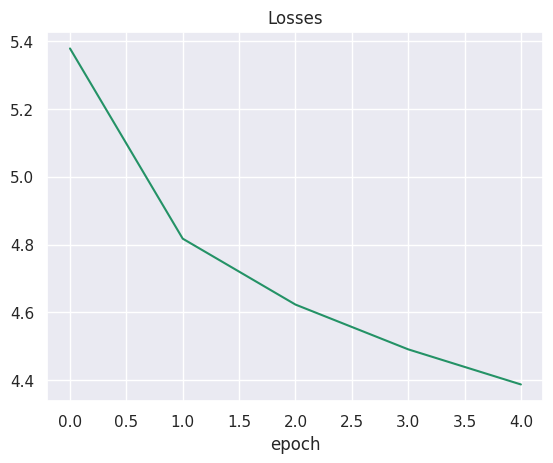

In [ ]:
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

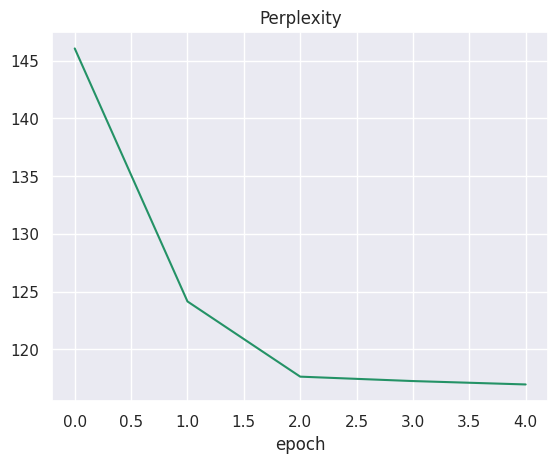

In [ ]:
plt.plot(np.arange(len(perplexities)), perplexities)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше.

In [ ]:
model = LanguageModel(hidden_dim=256, vocab_size=len(vocab),rec_layers = 2, rnn_type='lstm').to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())


In [ ]:
losses, perplexities = train_model(
    model, criterion, optimizer, train_dataloader, eval_dataloader, num_epochs=6
)

print("Потери на обучении:", losses)
print("Перплексия на валидации:", perplexities)

Training epoch 1/6:: 100%|██████████| 1256/1256 [02:24<00:00,  8.68it/s]


Epoch 1/6:
  Train Loss: 5.8072
  Val Perplexity: 176.6134


Training epoch 2/6:: 100%|██████████| 1256/1256 [02:25<00:00,  8.64it/s]


Epoch 2/6:
  Train Loss: 4.9910
  Val Perplexity: 133.8844


Training epoch 3/6:: 100%|██████████| 1256/1256 [02:25<00:00,  8.62it/s]


Epoch 3/6:
  Train Loss: 4.7442
  Val Perplexity: 119.6861


Training epoch 4/6:: 100%|██████████| 1256/1256 [02:25<00:00,  8.62it/s]


Epoch 4/6:
  Train Loss: 4.5854
  Val Perplexity: 113.5500


Training epoch 5/6:: 100%|██████████| 1256/1256 [02:25<00:00,  8.63it/s]


Epoch 5/6:
  Train Loss: 4.4614
  Val Perplexity: 110.3205


Training epoch 6/6:: 100%|██████████| 1256/1256 [02:25<00:00,  8.61it/s]


Epoch 6/6:
  Train Loss: 4.3574
  Val Perplexity: 109.2790
Потери на обучении: [5.807215124938138, 4.9910357936172725, 4.744228405177973, 4.585432605758594, 4.461449067114265, 4.357391599067457]
Перплексия на валидации: [176.6133872840055, 133.8844008233137, 119.68605216445437, 113.5500400324536, 110.3205478449536, 109.27898844336248]


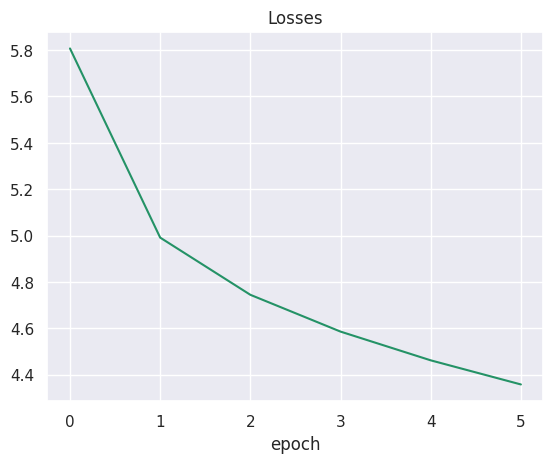

In [ ]:
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

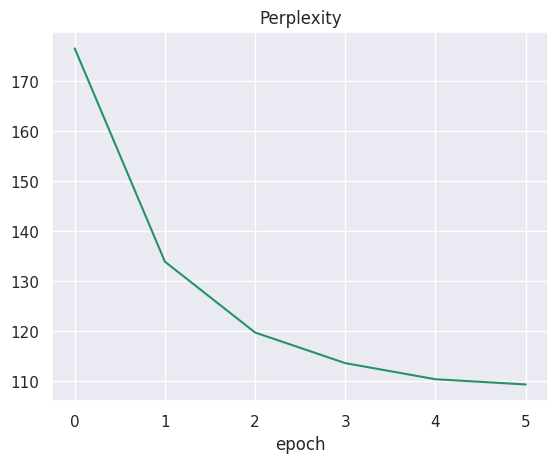

In [ ]:
plt.plot(np.arange(len(perplexities)), perplexities)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

In [ ]:
model = LanguageModel(hidden_dim=512, vocab_size=len(vocab), dropout_part = 0, rnn_type='gru').to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
losses, perplexities = train_model(
    model, criterion, optimizer, train_dataloader, eval_dataloader, num_epochs=3
)

print("Потери на обучении:", losses)
print("Перплексия на валидации:", perplexities)

Training epoch 1/3:: 100%|██████████| 1256/1256 [03:55<00:00,  5.34it/s]


Epoch 1/3:
  Train Loss: 5.1369
  Val Perplexity: 113.2793


Training epoch 2/3:: 100%|██████████| 1256/1256 [03:54<00:00,  5.35it/s]


Epoch 2/3:
  Train Loss: 4.5013
  Val Perplexity: 100.0019


Training epoch 3/3:: 100%|██████████| 1256/1256 [03:54<00:00,  5.35it/s]


Epoch 3/3:
  Train Loss: 4.2036
  Val Perplexity: 100.3016
Потери на обучении: [5.136879950951618, 4.501264847387933, 4.203590759046518]
Перплексия на валидации: [113.27928851668243, 100.00186220399893, 100.30158374567701]


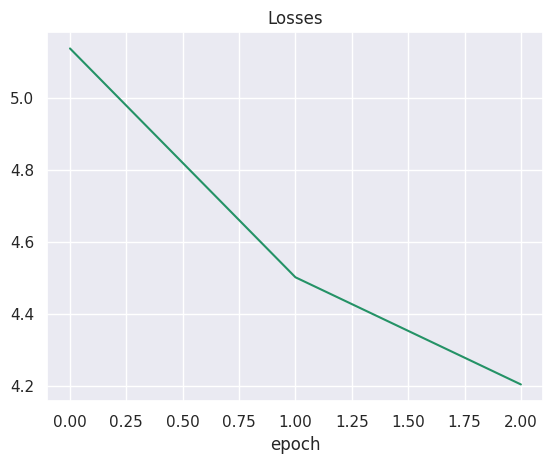

In [ ]:
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

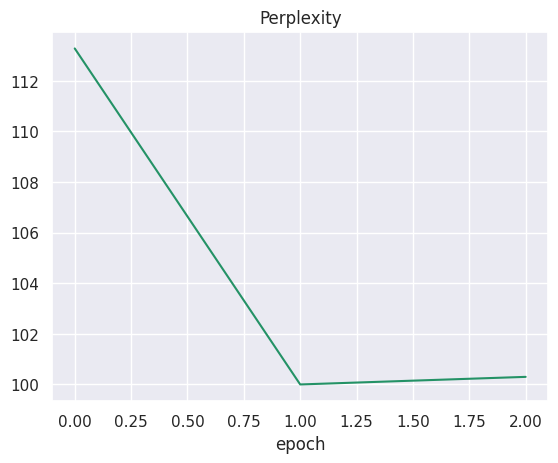

In [ ]:
plt.plot(np.arange(len(perplexities)), perplexities)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

In [ ]:
def generate_sequence(model, starting_seq: str, max_seq_len: int = 128) -> str:
    device = 'cpu'
    model = model.to(device)

    input_words = word_tokenize(starting_seq.lower())
    input_ids = [word2ind['<bos>']] + [
        word2ind.get(word, word2ind['<unk>']) for word in input_words
    ]
    input_ids = torch.LongTensor(input_ids).to(device)

    model.eval()
    with torch.no_grad():
        for i in range(max_seq_len):
            next_word_distribution = model(input_ids)[-1]

            next_word_id = next_word_distribution.squeeze().argmax()

            input_ids = torch.cat([input_ids, next_word_id.unsqueeze(0)])

            if next_word_id.item() == word2ind['<eos>']:
                break

    generated_words = [ind2word[idx.item()] for idx in input_ids]
    generated_sequence = ' '.join(generated_words)

    return generated_sequence

In [ ]:
starting_seqs = [
    "do you think",
    "i love",
    "to be honest"
]

for starting_seq in starting_seqs:
  print(generate_sequence(model, starting_seq = starting_seq))

<bos> do you think that you 're a fan of the original movies . <eos>
<bos> i love the movie and i have to say that it 's a very good movie . <eos>
<bos> to be honest , i would n't recommend this movie to anyone . <eos>


In [ ]:
starting_seqs = [
    "I don't know",
    "I like",
    "do you see"
]

for starting_seq in starting_seqs:
  print(generate_sequence(model, starting_seq = starting_seq))

<bos> i do n't know if the movie is about to be a good thing , but it 's not . <eos>
<bos> i like the eclectic , but i do n't know why . <eos>
<bos> do you see a movie like this ? <eos>


### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.

Наилучшие результаты показала модель с GRU (hidden_dim=512). Она быстро обучается и достигает самой низкой перплексии на валидации. Однако для улучшения обобщающей способности рекомендуется добавить dropout. Модели с LSTM и базовой RNN также показывают хорошие результаты, но требуют доработки для снижения перплексии.